In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
df.profile_report()

In [188]:
#Looking at Building class category - 01 ONE FAMILY DWELLINGS has 5061 rows
df.BUILDING_CLASS_CATEGORY.value_counts()
#Subsetting data to one family dwellings
df = df.query('BUILDING_CLASS_CATEGORY == "01 ONE FAMILY DWELLINGS"')
df.shape

(5061, 21)

In [189]:
# Getting the price statistics of the sub data
df.SALE_PRICE.describe()
#Subsetting the data to sale price between 100 thousand and two million
df = df.query('SALE_PRICE>100000 & SALE_PRICE<2000000')
print(df.shape)
df.SALE_PRICE.describe()

(3151, 21)


count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [190]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
#chanding sale date to date time format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)

In [192]:
df.SALE_DATE.dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: SALE_DATE, dtype: int64

In [193]:
#Splitting data into train and test
train = df[df.SALE_DATE.dt.month != 4].copy()
test = df[df.SALE_DATE.dt.month == 4].copy()
train.shape,test.shape

((2507, 21), (644, 21))

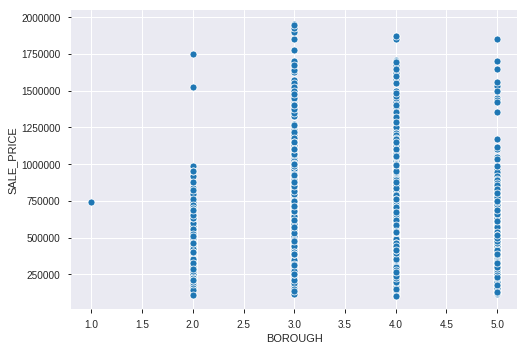

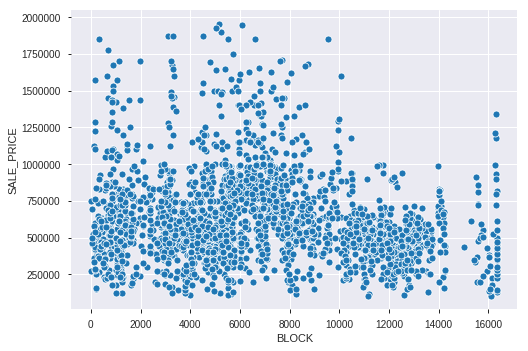

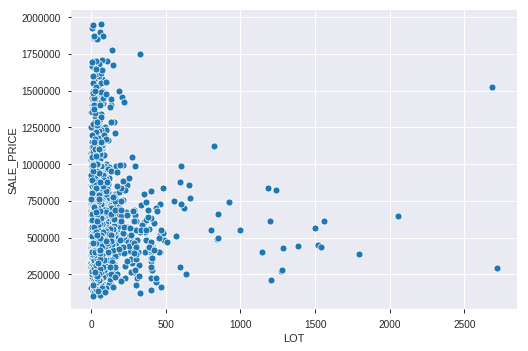

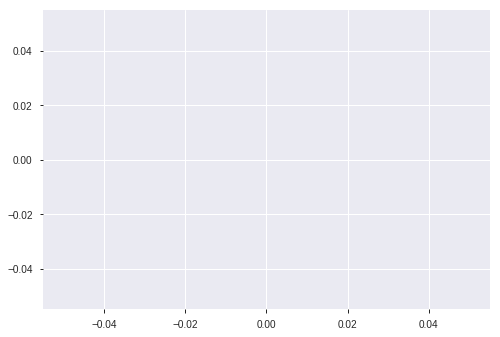

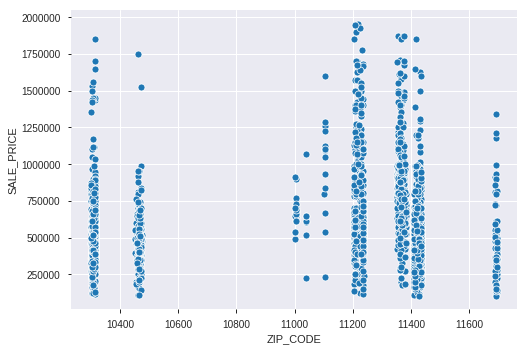

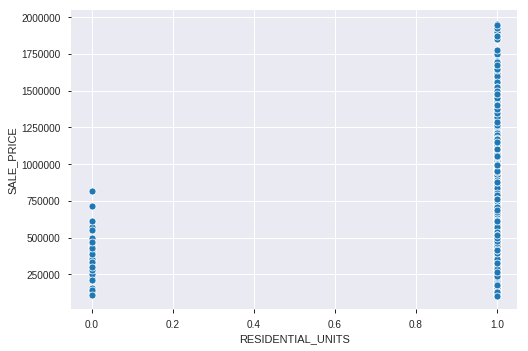

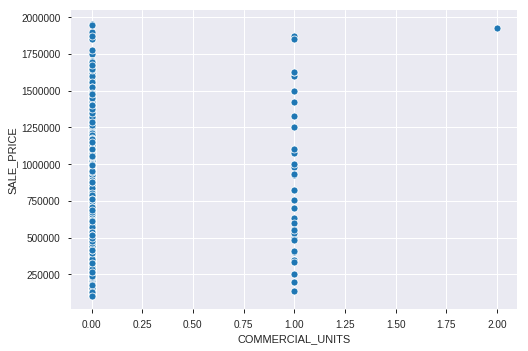

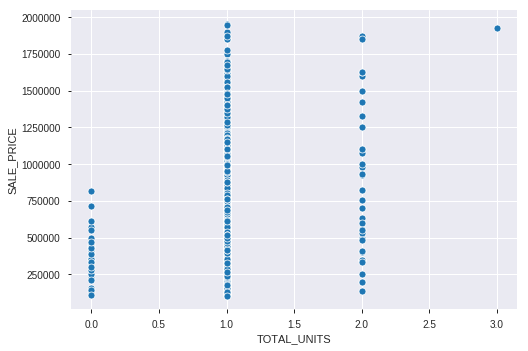

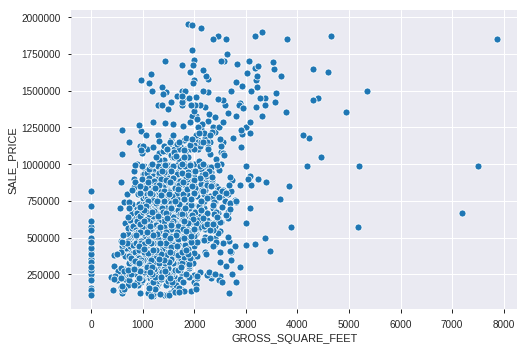

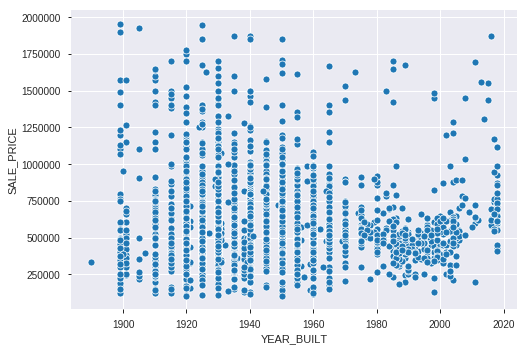

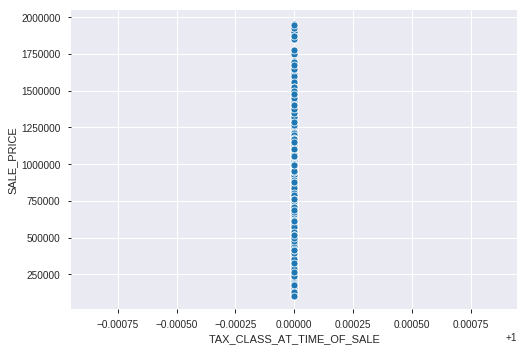

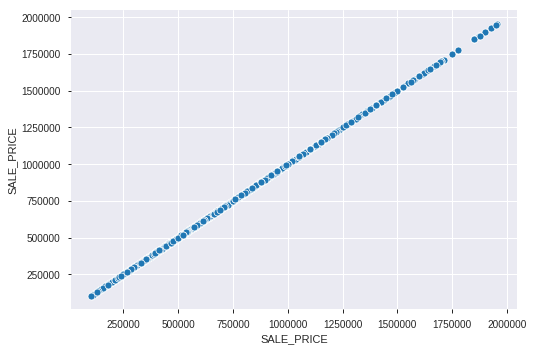

In [194]:
#Using visualisation to understand features
import matplotlib.pyplot as plt
import seaborn as sns
for col in train.select_dtypes('number'):
  ax = sns.scatterplot(x=col,y='SALE_PRICE',data=train)
  plt.show()
  

In [195]:
#checking for GROSS_SQUARE_FEET is zero
train.query('GROSS_SQUARE_FEET==0').describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,31.000000,31.000000,31.000000,0.0,31.000000,31.0,31.0,31.0,31.0,31.000000,31.0,31.0000
mean,3.354839,12849.516129,222.354839,NaN,11299.580645,0.0,0.0,0.0,0.0,1932.935484,1.0,392900.0000
std,0.950382,5153.738474,173.539918,NaN,585.435267,0.0,0.0,0.0,0.0,7.637345,0.0,168174.8039
min,2.000000,5455.000000,1.000000,NaN,10465.000000,0.0,0.0,0.0,0.0,1921.000000,1.0,110000.0000
25%,2.000000,5510.500000,50.000000,NaN,10465.000000,0.0,0.0,0.0,0.0,1923.000000,1.0,288500.0000
50%,4.000000,16350.000000,300.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,1938.000000,1.0,390000.0000
75%,4.000000,16350.000000,400.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,1938.000000,1.0,462500.0000
max,4.000000,16350.000000,400.000000,NaN,11697.000000,0.0,0.0,0.0,0.0,1938.000000,1.0,820000.0000


In [196]:
train.query('GROSS_SQUARE_FEET==0').describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,31,31,31,31,31,0.0,31,31,31
unique,2,1,1,1,31,0.0,1,1,22
top,BREEZY POINT,01 ONE FAMILY DWELLINGS,1D,A8,"936 BAYSIDE, 181",NaN,0,A8,2019-01-16 00:00:00
freq,21,31,31,31,1,NaN,31,31,3
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-26 00:00:00


In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

#Zip code as a categorical feature and reducing the cardinal feature
train['ZIP_CODE'] = train['ZIP_CODE'].astype(str)
test['ZIP_CODE'] = test['ZIP_CODE'].astype(str)

# Get a list of the top 10 neighborhoods
top10zipcodes = train['ZIP_CODE'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'
test.loc[~test['ZIP_CODE'].isin(top10zipcodes), 'ZIP_CODE'] = 'OTHER'


# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'


In [0]:
#Dropping columns Address it has null values and apartment number and TAX_CLASS_AT_TIME_OF_SALE as they have single value
# train = train.drop(columns=['EASE-MENT','ADDRESS','APARTMENT_NUMBER','TAX_CLASS_AT_TIME_OF_SALE'])
# test = test.drop(columns=['EASE-MENT','ADDRESS','APARTMENT_NUMBER','TAX_CLASS_AT_TIME_OF_SALE'])

In [0]:
#Converting land square feet to number
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',','').str.replace(' ','').astype(int)

In [0]:
#Binning Year Built as category value
year_bins = [year for year in range(int(train.YEAR_BUILT.min())-1,int(train.YEAR_BUILT.max())+11,10)]
train['YEAR_BUILT'] = pd.cut(train['YEAR_BUILT'],year_bins)
test['YEAR_BUILT'] = pd.cut(test['YEAR_BUILT'],year_bins)

In [201]:
year_bins

[1889,
 1899,
 1909,
 1919,
 1929,
 1939,
 1949,
 1959,
 1969,
 1979,
 1989,
 1999,
 2009,
 2019]

In [208]:
for col in train.select_dtypes(include='number'):
  print(col,train[col].nunique())

BLOCK 2060
LOT 304
EASE-MENT 0
RESIDENTIAL_UNITS 2
COMMERCIAL_UNITS 3
TOTAL_UNITS 4
LAND_SQUARE_FEET 887
GROSS_SQUARE_FEET 922
TAX_CLASS_AT_TIME_OF_SALE 1
SALE_PRICE 880


In [202]:
for col in train.select_dtypes(exclude='number'):
  print(col,train[col].nunique())

BOROUGH 5
NEIGHBORHOOD 11
BUILDING_CLASS_CATEGORY 1
TAX_CLASS_AT_PRESENT 2
BUILDING_CLASS_AT_PRESENT 13
ADDRESS 2497
APARTMENT_NUMBER 1
ZIP_CODE 11
YEAR_BUILT 13
BUILDING_CLASS_AT_TIME_OF_SALE 11
SALE_DATE 68


In [0]:
target = 'SALE_PRICE'
cat_columns = ['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
numerical_columns = list(train.select_dtypes(include='number').columns.drop([target,'EASE-MENT']))
features = cat_columns+numerical_columns

In [223]:
train[cat_columns].dtypes

BOROUGH                             object
NEIGHBORHOOD                        object
TAX_CLASS_AT_PRESENT                object
BUILDING_CLASS_AT_PRESENT           object
ZIP_CODE                            object
YEAR_BUILT                        category
BUILDING_CLASS_AT_TIME_OF_SALE      object
dtype: object

In [220]:
train[features].isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
TAX_CLASS_AT_PRESENT              0
BUILDING_CLASS_AT_PRESENT         0
ZIP_CODE                          0
YEAR_BUILT                        0
BUILDING_CLASS_AT_TIME_OF_SALE    0
BLOCK                             0
LOT                               0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
TAX_CLASS_AT_TIME_OF_SALE         0
dtype: int64

In [226]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE_OTHER,ZIP_CODE_11413.0,ZIP_CODE_11434.0,ZIP_CODE_10312.0,ZIP_CODE_10314.0,ZIP_CODE_11234.0,ZIP_CODE_10304.0,ZIP_CODE_10306.0,ZIP_CODE_10305.0,ZIP_CODE_11412.0,ZIP_CODE_10465.0,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BLOCK,LOT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5495,801,1.0,0.0,1.0,6800,1325.0,1
61,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7918,72,1.0,0.0,1.0,4000,2001.0,1
78,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4210,19,1.0,0.0,1.0,3500,2043.0,1
108,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5212,69,1.0,0.0,1.0,4000,2680.0,1
111,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7930,121,1.0,0.0,1.0,1710,1872.0,1


In [0]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

y_train = train[target]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(train[features])
X_test_encoded = encoder.transform(test[features])

scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)
X_train_scaled = X_train_encoded
X_test_scaled = X_test_encoded

In [243]:
X_train_encoded.shape,X_test_encoded.shape,X_train_scaled.shape,X_test_scaled.shape

((2507, 61), (644, 61), (2507, 61), (644, 61))

In [244]:
for k in range(1,(X_train_scaled.shape[1])+1):

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selector =  selector.fit_transform(X_train_scaled,y_train)
  X_test_selector = selector.transform(X_test_scaled)
  model = LinearRegression()
  model.fit(X_train_selector,y_train)
  train_predict = model.predict(X_train_selector)
  test_predict = model.predict(X_test_selector)
  print(f'{k} for Train: {mean_absolute_error(y_train,train_predict)} and Test:{mean_absolute_error(y_test,test_predict)}')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

1 for Train: 193398.04687040884 and Test:183640.5858012459
2 for Train: 190487.63900423868 and Test:179554.76843033519
3 for Train: 189889.8505699307 and Test:179291.46658251373
4 for Train: 189889.85056993162 and Test:179291.46658251635
5 for Train: 182256.91969999528 and Test:178896.91028453395
6 for Train: 178115.5688499868 and Test:174122.9846209879
7 for Train: 177546.28202554028 and Test:173275.65753780238
8 for Train: 171816.50040600126 and Test:172467.019854736
9 for Train: 167730.5029514282 and Test:168806.12088581134
10 for Train: 167725.4521365043 and Test:168798.2389982504
11 for Train: 156790.68329068305 and Test:156847.99499564094
12 for Train: 155046.33265624553 and Test:157745.4382628453
13 for Train: 154092.10861459505 and Test:156566.1565391213
14 for Train: 154103.78466181032 and Test:156576.06169523814
15 for Train: 154106.83552780788 and Test:156580.50743082276
16 for Train: 154104.9217794757 and Test:156478.39364405963
17 for Train: 153992.7418764345 and Test:1564

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return

24 for Train: 152681.69916040258 and Test:158198.59719321405
25 for Train: 152592.83986471797 and Test:158559.2294828935
26 for Train: 152590.32073497883 and Test:158559.61025987324
27 for Train: 152590.3207349858 and Test:158559.6102598748
28 for Train: 152590.32073500007 and Test:158559.61025988733
29 for Train: 152590.3207349751 and Test:158559.610259873
30 for Train: 152590.3207349772 and Test:158296.7880576609
31 for Train: 152590.32073499667 and Test:158180.65731716715
32 for Train: 152590.32073499533 and Test:158115.20180888442
33 for Train: 152590.3207349854 and Test:158073.19304982477
34 for Train: 152227.7018167605 and Test:157979.88943538777
35 for Train: 151995.90523168226 and Test:157556.4651667815
36 for Train: 152025.43088363868 and Test:157502.2930956184
37 for Train: 152051.07318797757 and Test:157497.93387948547
38 for Train: 152051.0731879832 and Test:157497.93387949292
39 for Train: 151372.16059654686 and Test:157781.32716353794
40 for Train: 151173.3767491484 and T

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
 

41 for Train: 151178.01128093302 and Test:157674.35196778303
42 for Train: 150694.88971570125 and Test:157706.94614062324
43 for Train: 150702.59276816162 and Test:157719.79100892588
44 for Train: 150702.59276818816 and Test:157721.4400091838
45 for Train: 150500.05665600952 and Test:157778.02660577337
46 for Train: 150081.50360586375 and Test:157268.3712324408
47 for Train: 150081.50360586226 and Test:157268.37123244352
48 for Train: 150005.20497396908 and Test:157257.45505798832
49 for Train: 150005.20497396568 and Test:157257.45505799382
50 for Train: 149348.86935886493 and Test:156189.0749154781
51 for Train: 149461.49101645395 and Test:156228.06607617016
52 for Train: 149474.95620479583 and Test:156268.47713813046
53 for Train: 149430.17284935748 and Test:156256.9138434156
54 for Train: 149197.08431637002 and Test:156262.86405752803
55 for Train: 148750.62346122737 and Test:155067.3935406986
56 for Train: 148750.623461302 and Test:155067.39354072855
57 for Train: 148750.6234612478

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.